# Segmentation des images de feuilles 
# par un modèle de Deep Learning type U-Net



In [ ]:
### Import du google drive pour l'enregistrement du modèle ou des poids
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Principe de la segmentation**

La segmentation consiste à déterminer où se trouve l'objet d'intérêt dans l'image et de supprimer l'arrière plan.

Une méthode possible est l'utilisation d'un masque. Un masque est une image contenant seulement deux valeurs pour chaque pixel : 0 ou 1.
Un pixel avec la valeur 1 est un pixel de l'objet à segmenter. Sinon le pixel correspond à l'arrière-plan et prend la valeur 0.
On obtient ainsi une image en noir et blanc avec en blanc l'espace correspondant à l'objet.

Le modèle développé va prendre en entrée une image de feuille et renverra un masque de cette feuille.

## **Instanciation du modèle**

Premièrement, il est nécessaire de créer l'architecture du modèle.

In [ ]:
### Import des modules nécessaires pour l'ensemble du travail

import numpy as np 
import os
import glob
import cv2
from tensorflow.keras import callbacks
import pandas as pd
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras

In [ ]:
### Définition d'une fonction de perte : Coefficient de Dice
def LossDice(y_true, y_pred):
  numerateur  =tf.reduce_sum(y_true*y_pred, axis=(1, 2))
  denominateur=tf.reduce_sum(y_true+y_pred, axis=(1, 2))
  dice=2*numerateur/(denominateur+1E-4)
  return 1-dice

In [ ]:
### Définition de la structure du modèle avec ses différentes couches

def unet(pretrained_weights = None, input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=2)(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    ### Compilation du modèle avec la fonction de perte 'loss dice' et la métrique 'accuracy'
    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(lr=1e-3), loss=LossDice,
                  metrics=['accuracy'])
    
    model.summary()

    ### Si le modèle a précédemment été entrainé, les poids sauvegardés sont chargés
    if (pretrained_weights):
    	model.load_weights(pretrained_weights)
    if (pretrained_weights):
    	print("\nLe modèle a été instancié avec les poids chargés.")
     
    
     
    return model

In [ ]:
### Chargement de poids sauvegardés s'ils existent
export_dir='/content/drive/MyDrive/'
pretrained_weights = None
if os.path.exists(export_dir+'weights.h5'):
  pretrained_weights = export_dir+'weights.h5'
  
### Instanciation d'un modèle
unet=unet(input_size=(256,256,3), pretrained_weights=pretrained_weights)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## **Importation et mis en forme des données**



Les données sont récupérées sur kaggle. Les images segmentées présentes dans ce jeu de données sont transformées en masque.

In [ ]:
### L'importation des données se fait directement par kaggle
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ralaivaomathis","key":"638bba9daf4d63aeec6be9b4a3d0ac7a"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d abdallahalidev/plantvillage-dataset
### Les données seront stockées dans un dossier 'dataset'
! mkdir dataset
! unzip plantvillage-dataset.zip -d dataset

Dans la partie suivante, nous allons convertir les images segmentées du jeu de données en masques. 

En effet, le modèle est plus performant à prédire des masques que des images segmentées directement.

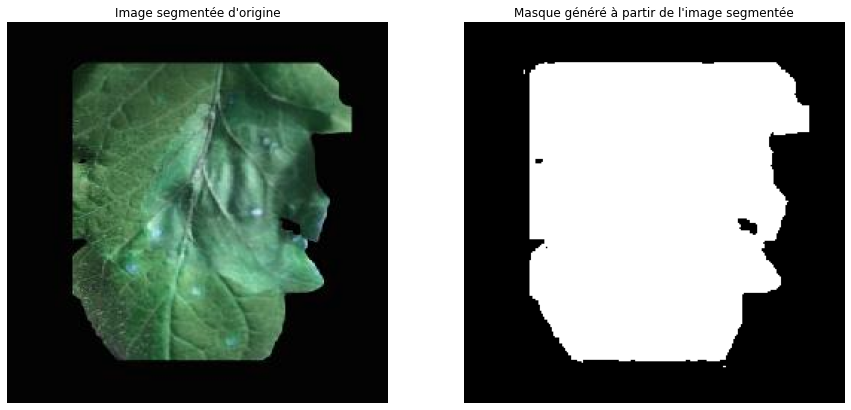

In [ ]:
### Génération de masques à partir des images segmentées du jeu de données


### Premièrement, on récupère les chemins des dossiers contenant les images

path_folders=glob.glob('/content/dataset/plantvillage dataset/segmented/**')

### Affichage d'un exemple d'image segmentée

path_example= glob.glob(path_folders[0]+'/**')[0]
plt.figure(figsize=(15,7))
plt.subplot(121)
example=cv2.imread(path_example)
plt.imshow(example)
plt.title("Image segmentée d'origine")
plt.axis('off')

### Transformation des images segmentées en masques

threshold=20
for path in path_folders:
  for fichier in glob.glob(path+'/**'):
      img=cv2.imread(fichier)
      if len(img.shape)==3:

        ### La moyenne des pixels RGB est calculée et un seuil est défini pour séparer les pixels
        ### de la feuille et le reste. 
        ### La valeur de 1 est attribué pour un pixel de la feuille, le pixel prend la valeur 0 sinon.

          img_mask=(img.mean(axis=2)>threshold).astype(int)
          cv2.imwrite(fichier,img_mask)

### Exemple de masque produit

plt.subplot(122)
example=cv2.imread(path_example,cv2.IMREAD_GRAYSCALE)
plt.imshow(example*255,cmap='gray')
plt.title("Masque généré à partir de l'image segmentée")
plt.axis('off');

In [ ]:
### Création d'un dataframe contenant les chemins des images et des masques correspondants

### On récupère les chemins des masques et des images

directory_images='/content/dataset/plantvillage dataset/color'
directory_masks='/content/dataset/plantvillage dataset/segmented'
path_masks=[]
path_images=[]

for path in glob.glob(directory_masks+'/'+'**'):
    path_masks+=glob.glob(path+'/'+'**')

for path in glob.glob(directory_images+'/'+'**'):
    path_images+=glob.glob(path+'/'+'**')

### Les listes de chemins des masks et images sont triées 
### pour s'assurer de leur correspondance

path_masks=sorted(path_masks)
path_images=sorted(path_images)

### Suppression d'un mask sans image correspondante

indice=12292
print(path_masks[indice],path_images[indice])
del(path_masks[indice])

### Création du DataFrame

dico={'Image':path_images,'Mask':path_masks}
df=pd.DataFrame(dico)

/content/dataset/plantvillage dataset/segmented/Grape___Esca_(Black_Measles)/7e1fd9b9-1fd9-4f98-93f5-8cf9ebc60dd9___FAM_B.Msls 4430_final_masked.jpg /content/dataset/plantvillage dataset/color/Grape___Esca_(Black_Measles)/7e4cf44f-02ec-4812-9afa-b19f45add835___FAM_B.Msls 4422.JPG


Les jeux de données d'entraînement, de validation et de test sont générés à partir du DataFrame créer. 
Les données seront chargées au fur et à mesure de l'entrainement du modèle par une fonction définie ci-dessous.

Pour l'entrainement du modèle, les features correspondent aux images et les valeurs à prédire (les labels) sont les masques correspondants.


In [ ]:
### Définition de fonctions de chargement et transformation
### des images ou masques à partir des chemins

import tensorflow as tf
def load_image(filepath,resize=(256,256)):
    # Charger l'information brute en mémoire
    im = tf.io.read_file(filepath)
    # Décoder l'information en un tensorflow RGB (3 channels).
    im = tf.io.decode_jpeg(im, channels=3)
    #Redimensionner l'image
    return tf.image.resize(im, size=resize)
  
def load_mask(filepath,resize=(256,256)):
    im = tf.io.read_file(filepath)
    ### Dans le cas des masques, l'image est en noir et blanc, il n'y a donc qu'une valeur par pixel
    im = tf.io.decode_jpeg(im, channels=1)
    return tf.image.resize(im, size=resize)

In [ ]:
### Création du jeu d'entrainement, de validation et de test
### La fonction définie au dessus est utilisée pour charger les images et 
### masques au fur et à mesure de l'entrainement

X_train_path, X_test_path, y_train_path, y_test_path = train_test_split(df.Image, df.Mask, test_size=0.2, random_state=456)
X_train_path, X_val_path, y_train_path, y_val_path = train_test_split(X_train_path, y_train_path, test_size=0.2, random_state=456)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path,y_train_path))
dataset_train = dataset_train.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)

dataset_val = tf.data.Dataset.from_tensor_slices((X_val_path,y_val_path))
dataset_val = dataset_val.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path,y_test_path))
dataset_test = dataset_test.map(lambda x, y : [load_image(x),load_mask(y)], num_parallel_calls=-1).batch(1)


In [ ]:
### Définition de callbacks et entrainement du modèle

### Sauvegarde automatique des poids
checkpoint = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/checkpoint/weights.h5', 
                                       monitor = 'loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

### 'Callback' permettant d'ajuster le taux d'apprentissage au cours de l'entrainement
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'loss',
                                         patience=1,
                                         factor=0.1,
                                         verbose=2,
                                         mode='min')

training=unet.fit(dataset_train, epochs=3, validation_data=dataset_val, callbacks = [lr_plateau, checkpoint])

Epoch 1/3
34755/34755 [==============================] - 1048s 30ms/step - loss: 0.0610 - accuracy: 0.9497 - val_loss: 0.0690 - val_accuracy: 0.9416
Epoch 2/3
34755/34755 [==============================] - 1037s 30ms/step - loss: 0.0613 - accuracy: 0.9495 - val_loss: 0.0649 - val_accuracy: 0.9460
Epoch 3/3
34755/34755 [==============================] - 1034s 30ms/step - loss: 0.0615 - accuracy: 0.9492 - val_loss: 0.0644 - val_accuracy: 0.9460

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [ ]:
### Sauvegarde des poids et du modèle entrainé
unet.save_weights(export_dir+'weights.h5')
unet.save(export_dir+'model.h5')

## **Evaluation de la précision du modèle et réalisation d'essais sur de nouvelles images**

Le modèle est évalué sur le jeu de donnée de test et des images d'un autre jeu de données vont être chargées pour pouvoir tester la segmentation générée.

In [ ]:
### Evaluation de la précision du modèle sur le jeu de test
evaluation=unet.evaluate(dataset_test)
print('Précision du modèle sur le jeu de test :',np.round(evaluation[1],2),"\n",
      'Perte du modèle sur le jeu de test :',np.round(evaluation[0],2))

10861/10861 [==============================] - 95s 9ms/step - loss: 0.0644 - accuracy: 0.9452
Précision du modèle sur le jeu de test : 0.95 
 Perte du modèle sur le jeu de test : 0.06


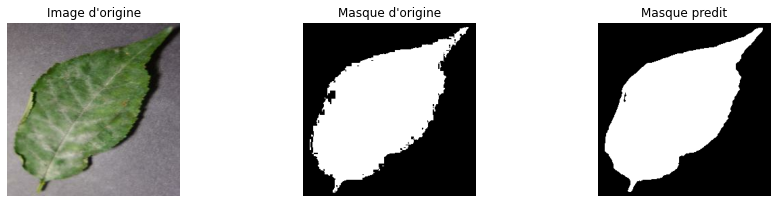

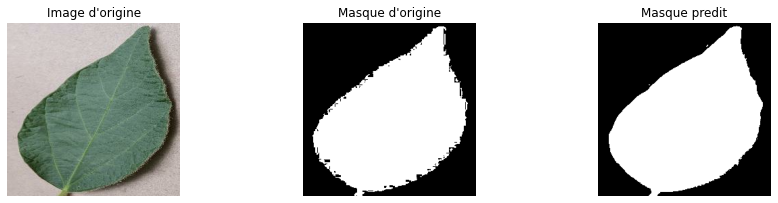

In [ ]:
### Démonstration d'une prédiction de masque en comparaison avec un masque
### fait à partir de l'image segmentée du jeu de donnée Test

size=2
indexes=np.random.choice(np.array(X_test_path.index),size=2)

i=0
for idx in indexes:
  image=load_image(X_test_path[idx])
  img=tf.reshape(image,(1,256,256,3))
  mask_pred=unet.predict(img)
  mask_true=load_mask(y_test_path[idx])
  image=tf.cast(image,dtype=tf.int32)

  plt.figure(figsize=(15,7))

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(image)
  plt.axis("off")
  plt.title("Image d'origine")

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(tf.reshape(mask_true,(256,256)),cmap='gray')
  plt.axis("off")
  plt.title("Masque fait à partir de l'image segmentée")

  i+=1
  plt.subplot(size,3,i)
  plt.imshow(tf.reshape(mask_pred,(256,256)),cmap='gray')
  plt.axis("off")
  plt.title("Masque predit par le modèle")

Une observation importante est mise en évidence par les images ci-dessus. Les masques générés par le modèle UNet semblent plus précis que ceux obtenus par transformation des images segmentées.

Cela explique le fait que le modèle n'arrive pas à converger à plus de 95% d'accuracy. Les masques sont bons mais ne correspondent pas tout à fait à ceux donnés en entrainement, il y a donc un écart qui fait chuté l'accuracy.

In [1]:
### Importation d'un nouveau jeu de donnée pour voir la segmentation réalisée
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset
### Les données seront stockés dans un dossier 'dataset_essais'
! mkdir dataset_essais
! unzip new-plant-diseases-dataset.zip -d dataset_essais

In [ ]:
### On récupère les chemins des images à segmenter
directory_images='/content/dataset_essais/test/'
path_images=[]
for path in glob.glob(directory_images+'/'+'**'):
    path_images+=glob.glob(path+'/'+'**')


In [ ]:
### Chargement éventuel d'un modèle enregistré

if os.path.exists(export_dir+'saved_model.h5'):
  saved_unet= tf.keras.models.load_model(export_dir+'saved_model.h5')

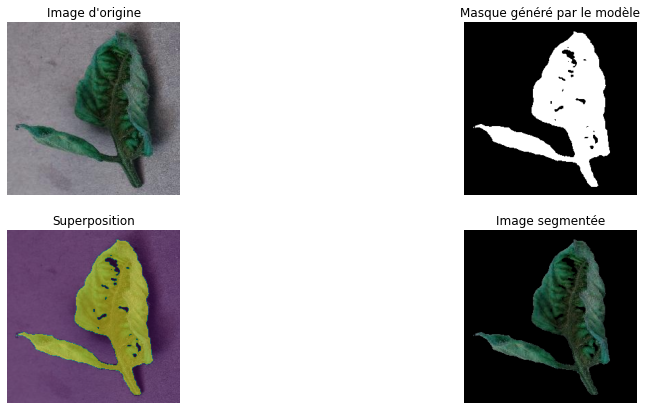

In [ ]:
### Une image est choisie au hasard et la segmentation est appliquée
chiffre=np.random.choice(range(len(path_images)),size=1)[0]
im=cv2.imread(path_images[chiffre])
mask=load_image(path_images[chiffre])
mask=tf.reshape(mask,(1,256,256,3))
pred=unet.predict(mask)
#pred = saved_unet.predict(mask)

plt.figure(figsize=(15,7))
plt.subplot(221)
plt.imshow(im)
plt.title("Image d'origine")
plt.axis('off')

plt.subplot(222)
plt.imshow(pred.reshape(256,256),cmap='gray')
plt.title("Masque généré par le modèle")
plt.axis('off')

### La segmentation est réalisée en multipliant le masque et l'image à segmenter
seg=(im*pred.reshape(256,256,1)).astype(int)
plt.subplot(224)
plt.imshow(seg)
plt.title("Image segmentée")
plt.axis('off');

### Superposition du masque et de l'image
seg=(im*pred.reshape(256,256,1)).astype(int)
plt.subplot(223)
plt.imshow(im)
plt.imshow(pred.reshape(256,256),alpha=0.5)
plt.title("Mise en évidence de la feuille sur l'image")
plt.axis('off');
